# BP神经网络分类Fashion MNIST数据集
09118241 陈嘉源

In [1]:
import cv2
import csv
import matplotlib.pyplot as plt
import numpy as np
import random
import os, struct

## 加载数据集

In [2]:
print('加载数据...')
#读取测试集
testpath = './test'
test = []
imagelist = os.listdir(testpath)
for i in range(len(imagelist)):
    image = cv2.imread('./test/'+str(i)+'.jpg',0)
    test.append(image)
test = np.array(test)
#读取训练集
labelpath = './train.csv'
label = []
data = []
with open(labelpath, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        img = cv2.imread(row[0],0)
        data.append(img)
        label.append(int(row[1]))
train = np.array(data)
print('finished')

加载数据...
finished


## 划分训练集、验证集、做数据增广

In [3]:
#训练集最后2000个样本构成验证集，前58000个为训练集
val_data = []
val_label = []
for k in range(2000):
    val_data.append(train[58000+k])
    val_label.append(label[58000+k])
val_data = np.array(val_data)
val_label = np.array(val_label)
train = train[0:58000]

In [4]:
#增广训练集，构成60000个样本点
for i in range(2000):
    img = train[i]
    trans_img = cv2.transpose(img)
    dst = cv2.flip(trans_img, 1) #旋转90度   
    np.append(train,dst)
    np.append(label,label[i])

## 搭建神经网络-前馈、反向传播、Mini-batch GD

In [5]:
class NeuralNet(object):
    # 初始化神经网络，sizes是神经网络的层数和每层神经元个数
    def __init__(self, sizes):
        self.sizes_ = sizes
        self.num_layers_ = len(sizes)  # 层数
        self.w_ = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]  #[784*40,40*10]
        self.b_ = [np.random.randn(y, 1) for y in sizes[1:]] #[40*1,10*1]
    # Sigmoid函数，
    def sigmoid(self, z):
        return 1.0/(1.0+np.exp(-z))
    
    # Sigmoid函数的导函数
    def sigmoid_prime(self, z):
        return self.sigmoid(z)*(1-self.sigmoid(z))
    
    def feedforward(self, x):
        for b, w in zip(self.b_, self.w_):
            x = self.sigmoid(np.dot(w, x)+b)
        return x
    def backprop(self, x, y):
        delta_b = [np.zeros(b.shape) for b in self.b_]
        delta_w = [np.zeros(w.shape) for w in self.w_]
 
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.b_, self.w_):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)
 
        delta = (activations[-1]-y) * self.sigmoid_prime(zs[-1])
        delta_b[-1] = delta
        delta_w[-1] = np.dot(delta, activations[-2].transpose())
 
        for l in range(2, self.num_layers_):
            z = zs[-l]
            sp = self.sigmoid_prime(z)
            delta = np.dot(self.w_[-l+1].transpose(), delta) * sp
            delta_b[-l] = delta
            delta_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (delta_b, delta_w)
 
    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.b_]
        nabla_w = [np.zeros(w.shape) for w in self.w_]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.w_ = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.w_, nabla_w)]
        self.b_ = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.b_, nabla_b)]
 
    # epochs：训练次数;mini_batch_size：每次训练样本数;eta：learning rate
    def MBGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        ac_list = []
        epoch_list = []
        if test_data:
            n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                #if (j+1)%10==0:
                    epoch_list.append(j)
                    print("Epoch {0}: {1} / {2}".format(j+1, self.evaluate(test_data), n_test))
                    ac_list.append(self.evaluate(test_data)/n_test) 
            else:
                print("Epoch {0} complete".format(j))
        plt.plot(epoch_list, ac_list)
        plt.show()
 
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)
 
    # 预测
    def predict(self, data):
        value = self.feedforward(data)
        return value.tolist().index(max(value))
    

def pack_data(image,label,dataset = "training_data"):
    '''
    构建dataset
    '''
    X = [np.reshape(x,(28*28,1)) for x in image]
    X = [x/255.0 for x in X]   # 灰度值范围(0-255)，转换为(0-1)
     
    # one_hot:将标签转化为10*1的向量   1-> [0,1.0,0,0,0,0,0,0,0]
    def vectorized_Y(y): 
        e = np.zeros((10, 1))
        e[int(y)] = 1.0
        return e
    if dataset == "training_data":
        Y = [vectorized_Y(y) for y in label]
        pack = list(zip(X, Y))
        return pack
    elif dataset == 'testing_data':
        pack = list(zip(X, label))
        return pack
    else:
        print('wrong')    

## 构造一个三层神经网络 (28*28->40->10)

隐藏层size为调参之后较优结果，可做一定调整

Epoch 1: 1478 / 2000
Epoch 2: 1539 / 2000
Epoch 3: 1560 / 2000
Epoch 4: 1585 / 2000
Epoch 5: 1589 / 2000
Epoch 6: 1596 / 2000
Epoch 7: 1588 / 2000
Epoch 8: 1600 / 2000
Epoch 9: 1611 / 2000
Epoch 10: 1605 / 2000
Epoch 11: 1601 / 2000
Epoch 12: 1610 / 2000
Epoch 13: 1614 / 2000
Epoch 14: 1620 / 2000
Epoch 15: 1618 / 2000
Epoch 16: 1610 / 2000
Epoch 17: 1616 / 2000
Epoch 18: 1632 / 2000
Epoch 19: 1619 / 2000
Epoch 20: 1629 / 2000
Epoch 21: 1634 / 2000
Epoch 22: 1626 / 2000
Epoch 23: 1626 / 2000
Epoch 24: 1624 / 2000
Epoch 25: 1626 / 2000
Epoch 26: 1633 / 2000
Epoch 27: 1636 / 2000
Epoch 28: 1646 / 2000
Epoch 29: 1628 / 2000
Epoch 30: 1632 / 2000


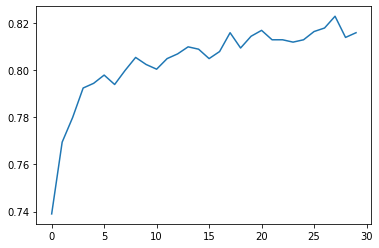

准确率:  0.816


In [8]:
input_size = 28*28
output_size = 10
net = NeuralNet([input_size, 42, output_size])
train_set = pack_data(train,label,dataset='training_data')
test_set = pack_data(val_data,val_label,dataset='testing_data')
net.MBGD(train_set, 30, 100, 2.7,test_data=test_set)
#准确率
correct = 0;
for test_feature in test_set:
    if net.predict(test_feature[0]) == test_feature[1]:
        correct += 1
print("准确率: ", correct/len(test_set))

## 在测试集上分类，写入csv

In [12]:
f = open('test_prediction.csv','w',encoding='utf-8')
csv_writer = csv.writer(f)
for i in range(len(test)):
    t = np.resize(test[i],(28*28,1))
    csv_writer.writerow([('./test/'+str(i)+'.jpg'), net.predict(t)])
print('finishied')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


finishied
